In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import os
import shutil
from sklearn.model_selection import train_test_split

In [8]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define directories for original dataset and split dataset
original_dataset_dir = '/Users/code/alzheimerDetect/ADNI_aug'
base_dir = '/Users/code/alzheimerDetect/split_dataset_ADNI_aug'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

# Define categories
categories = ['AD', 'CN', 'EMCI', 'LMCI']

# Clear old directories if they exist, then create new directories for training and testing data
if os.path.exists(base_dir):
    shutil.rmtree(base_dir)
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

for category in categories:
    os.makedirs(os.path.join(train_dir, category), exist_ok=True)
    os.makedirs(os.path.join(test_dir, category), exist_ok=True)

    # List files in the category directory and exclude directories
    category_dir = os.path.join(original_dataset_dir, category)
    files = [f for f in os.listdir(category_dir) if os.path.isfile(os.path.join(category_dir, f))]
    
    # Split the data
    train_files, test_files = train_test_split(files, test_size=0.2, random_state=42)
    
    # Copy files to train directory
    for file in train_files:
        src = os.path.join(category_dir, file)
        dst = os.path.join(train_dir, category, file)
        shutil.copyfile(src, dst)
    
    # Copy files to test directory
    for file in test_files:
        src = os.path.join(category_dir, file)
        dst = os.path.join(test_dir, category, file)
        shutil.copyfile(src, dst)

print("Dataset split into training and testing sets.")

Dataset split into training and testing sets.


In [9]:
# Data Preprocessing
train_datagen = ImageDataGenerator(
    rescale=1/255.0,
    validation_split=0.2  # 20% of the data will be used for validation
)

test_datagen = ImageDataGenerator(
    rescale=1/255.0
)

In [10]:
# Load training data and validation data from the training directory
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),  # Resize images to 150x150 pixels
    batch_size=32,
    class_mode='categorical',  # Adjusted for multi-class classification
    subset='training'  # Set as training data
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',  # Adjusted for multi-class classification
    subset='validation'  # Set as validation data
)

# Load test data from the test directory
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'  # Adjusted for multi-class classification
)

Found 21751 images belonging to 4 classes.
Found 5436 images belonging to 4 classes.
Found 6797 images belonging to 4 classes.


In [17]:
# Build the CNN Model
model = Sequential([
    Conv2D(32, (3, 3), activation='elu', input_shape=(150, 150, 3)),  # Change to 1 channel
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='elu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='elu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='elu'),
    Dropout(0.5),
    Dense(4, activation='softmax')  # output multi-class classification
])


In [18]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,035,716 (72.62 MB)

 Trainable params: 19,035,716 (72.62 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Compile the Model
model.compile(
    loss='categorical_crossentropy',  # Adjusted for multi-class classification
    optimizer='adam',
    metrics=['accuracy']
)

In [20]:
# Create an EarlyStopping callback
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

In [25]:
# Train the Model
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[callback]
)

Epoch 1/20
680/680 ━━━━━━━━━━━━━━━━━━━━ 108s 159ms/step - accuracy: 0.9707 - loss: 0.0807 - val_accuracy: 0.8766 - val_loss: 0.4449
Epoch 2/20
680/680 ━━━━━━━━━━━━━━━━━━━━ 109s 159ms/step - accuracy: 0.9909 - loss: 0.0263 - val_accuracy: 0.8804 - val_loss: 0.5289
Epoch 3/20
680/680 ━━━━━━━━━━━━━━━━━━━━ 108s 159ms/step - accuracy: 0.9856 - loss: 0.0418 - val_accuracy: 0.8635 - val_loss: 0.6674
Epoch 4/20
680/680 ━━━━━━━━━━━━━━━━━━━━ 108s 159ms/step - accuracy: 0.9302 - loss: 0.2915 - val_accuracy: 0.8773 - val_loss: 0.5591
Epoch 5/20
680/680 ━━━━━━━━━━━━━━━━━━━━ 109s 159ms/step - accuracy: 0.9800 - loss: 0.0606 - val_accuracy: 0.8769 - val_loss: 0.6923


In [26]:
# Evaluate the Model
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test accuracy: {test_accuracy:.4f}')

213/213 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.8750 - loss: 0.5323
Test accuracy: 0.8720


In [50]:
# Save the Model
model.save('alzheimers_detector_model_with_ADNI_aug_DS_cnn.h5')

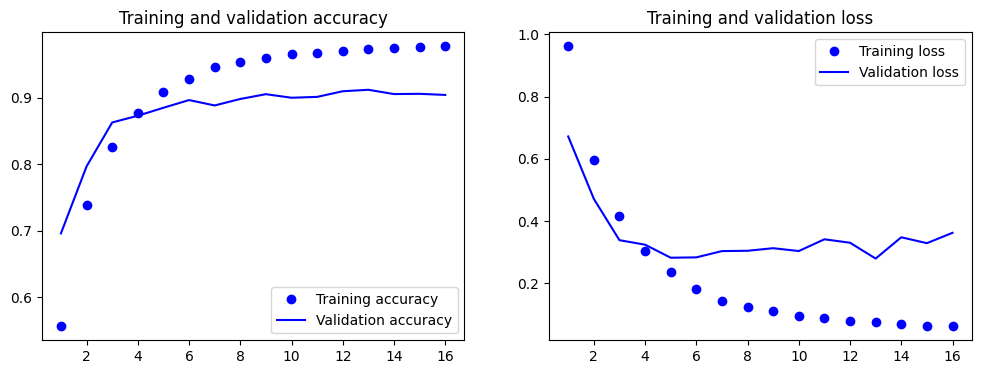

In [51]:
# Optionally, plot the training and validation accuracy and loss
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

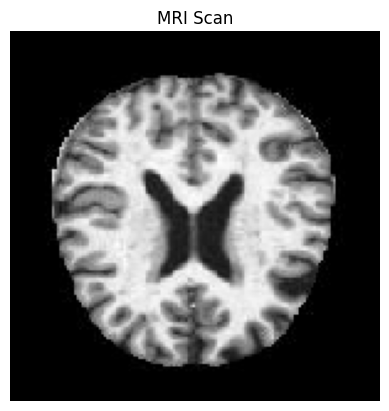

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
The model predicts: EMCI (1.0000)


In [53]:
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Define the path to the image
image_path = 'split_dataset/test/NonDemented/26 (63).jpg'

# Load the image
img = image.load_img(image_path, target_size=(150, 150))

# Display the image
plt.imshow(img)
plt.title("MRI Scan")
plt.axis('off')
plt.show()

# Preprocess the image
img_array = image.img_to_array(img)  # Convert the image to a numpy array
img_array = img_array / 255.0  # Rescale the image
img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions to match the model's input shape

# Make a prediction
prediction = model.predict(img_array)

# Define class labels
class_labels = ['AD', 'CN', 'EMCI', 'LMCI']

# Get the predicted class
predicted_class = class_labels[np.argmax(prediction[0])]

print(f'The model predicts: {predicted_class} ({prediction[0][np.argmax(prediction[0])]:.4f})')

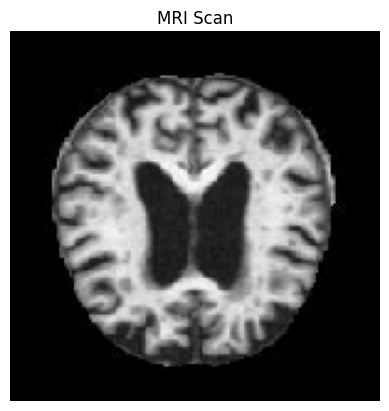

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
The model predicts: CN (0.9851)


In [37]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# Load the saved model
model = tf.keras.models.load_model('alzheimers_detector_model_with_ADNI_DS_cnn.h5')

# Define the path to the image
image_path = '/Users/arnabsahoo/Downloads/FinalPriject/Alzheimer_s Dataset/test/VeryMildDemented/26 (53).jpg'

# Load the image
img = image.load_img(image_path, target_size=(150, 150))

# Display the image
plt.imshow(img)
plt.title("MRI Scan")
plt.axis('off')
plt.show()

# Preprocess the image
img_array = image.img_to_array(img)  # Convert the image to a numpy array
img_array = img_array / 255.0  # Rescale the image
img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions to match the model's input shape

# Make a prediction
prediction = model.predict(img_array)

# Define class labels
class_labels = ['AD', 'CN', 'EMCI', 'LMCI']

# Get the predicted class
predicted_class = class_labels[np.argmax(prediction[0])]

print(f'The model predicts: {predicted_class} ({prediction[0][np.argmax(prediction[0])]:.4f})')

In [40]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Define the categories
categories = ['AD', 'CN', 'EMCI', 'LMCI']

# Load the model
model = tf.keras.models.load_model('alzheimers_detector_model_with_ADNI_DS_cnn.h5')

# Define the test data directory
test_dir = 'split_dataset_axial/test'

# Preprocess the data
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),  # Match this to the input size used during training
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Predict on the test data
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Evaluate the model manually
true_classes = test_generator.classes
accuracy_per_batch = []
loss_per_batch = []

for i, (images, labels) in enumerate(test_generator):
    if i >= len(test_generator):  # Stop when all batches completed
        break
    batch_loss, batch_accuracy = model.evaluate(images, labels, verbose=0)
    accuracy_per_batch.append(batch_accuracy)
    loss_per_batch.append(batch_loss)

print(f'Test Accuracy: {np.mean(accuracy_per_batch) * 100:.2f}%')

# print the categories corresponding to the predictions
# predicted_category_names = [categories[i] for i in predicted_classes]
# print(predicted_category_names)

Found 729 images belonging to 4 classes.
23/23 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step
Test Accuracy: 76.02%


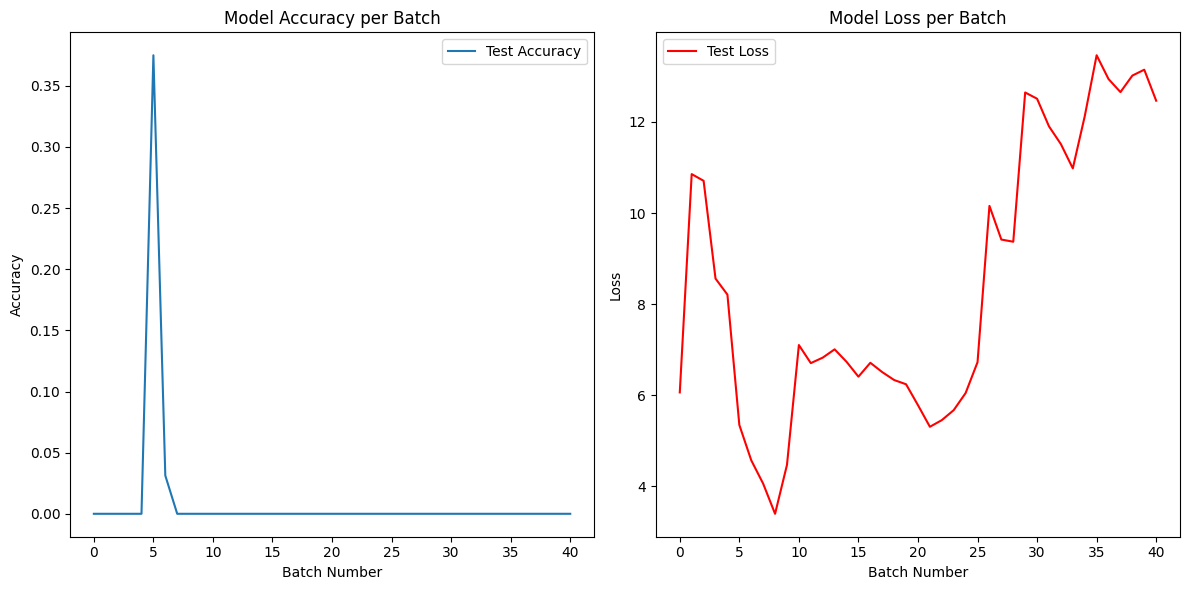

In [39]:
import matplotlib.pyplot as plt

# Plotting accuracy and loss for each batch
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(accuracy_per_batch, label='Test Accuracy')
plt.title('Model Accuracy per Batch')
plt.xlabel('Batch Number')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(loss_per_batch, label='Test Loss', color='red')
plt.title('Model Loss per Batch')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()